In [ ]:
import glob
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import torch 
from torchvision.transforms import functional as F
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon
from skimage.color import label2rgb
import colorsys
import random

# Model Imports
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
# packages for training the model
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

# pypi packages to install
pip install labelme2coco

Cloning into 'vision'...
remote: Enumerating objects: 31022, done.
remote: Counting objects: 100% (3565/3565), done.
remote: Compressing objects: 100% (828/828), done.
remote: Total 31022 (delta 2767), reused 3410 (delta 2668), pack-reused 27457
Receiving objects: 100% (31022/31022), 38.38 MiB | 24.65 MiB/s, done.
Resolving deltas: 100% (23383/23383), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
# New Imports
from engine import train_one_epoch, evaluate
import utils

import labelme2coco

In [ ]:
!git clone https://github.com/thsant/wgisd.git

Cloning into 'wgisd'...
remote: Enumerating objects: 4248, done.
remote: Counting objects: 100% (848/848), done.
remote: Compressing objects: 100% (839/839), done.
remote: Total 4248 (delta 19), reused 820 (delta 7), pack-reused 3400
Receiving objects: 100% (4248/4248), 1.39 GiB | 31.34 MiB/s, done.
Resolving deltas: 100% (342/342), done.
Checking out files: 100% (1849/1849), done.


In [ ]:
class GrapeDataset():
  def __init__(self, data_root):

    self.mask_npz = sorted(glob.glob(os.path.join(data_root, "*.npz")))
    images_jpg = sorted(glob.glob(os.path.join(data_root, "*.jpg")))
    bbox_txt = sorted(glob.glob(os.path.join(data_root, "*.txt")))
    assert len(images_jpg) == len(bbox_txt)

    # In wgisd dataset not all masks are paired with bbox and imgs. 
    image_names = [os.path.splitext(os.path.basename(fp))[0] for fp in images_jpg]
    mask_names = [os.path.splitext(os.path.basename(fp))[0] for fp in self.mask_npz]
    removable_ind = [ii for ii, n in enumerate(image_names) if n not in mask_names]

    self.images_jpg, self.bbox_txt = list(), list()
    for ii in range(len(images_jpg)):
      if ii not in removable_ind:
        self.images_jpg.append(images_jpg[ii])
        self.bbox_txt.append(bbox_txt[ii])

    # Checks on dataset
    assert len(self.images_jpg) == len(self.mask_npz) == len(self.bbox_txt)
    for ii in range(len(self.images_jpg)):
      assert os.path.splitext(os.path.basename(self.images_jpg[ii]))[0] == \
      os.path.splitext(os.path.basename(self.bbox_txt[ii]))[0] == \
      os.path.splitext(os.path.basename(self.mask_npz[ii]))[0]
    
    print("Dataset Passed Assertions")


  def __getitem__(self, idx):

    # Handle the img
    img = cv2.imread(self.images_jpg[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)

    # Handle the mask
    masks = np.load(self.mask_npz[idx])["arr_0"].astype(np.uint8)
    masks = np.moveaxis(masks, -1, 0)
    num_objs = masks.shape[0]
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    # Handle bboxes
    np_bbox_text = np.loadtxt(self.bbox_txt[idx], delimiter = " ", dtype = np.float32)
    bboxes = np_bbox_text[:, 1:]
    
    assert (bboxes.shape[0] == num_objs)

    _, height, width = img.shape
    scaled_boxes = []
    for box in bboxes:
        x1 = box[0] - box[2]/2
        x2 = box[0] + box[2]/2
        y1 = box[1] - box[3]/2
        y2 = box[1] + box[3]/2
        scaled_boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
    
    scaled_boxes = torch.as_tensor(scaled_boxes, dtype=torch.float32)

    #Create labels from masks
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])

    target = {
            "boxes": scaled_boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id
        }
    
    return img, target

  def __len__(self):
    return len(self.images_jpg)


In [ ]:
train_batch_size = 2
def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])

grape_Dataset = GrapeDataset("/content/wgisd/data")
train_loader = torch.utils.data.DataLoader(grape_Dataset, batch_size = train_batch_size, shuffle = False, collate_fn = collate_fn)

Dataset Passed Assertions


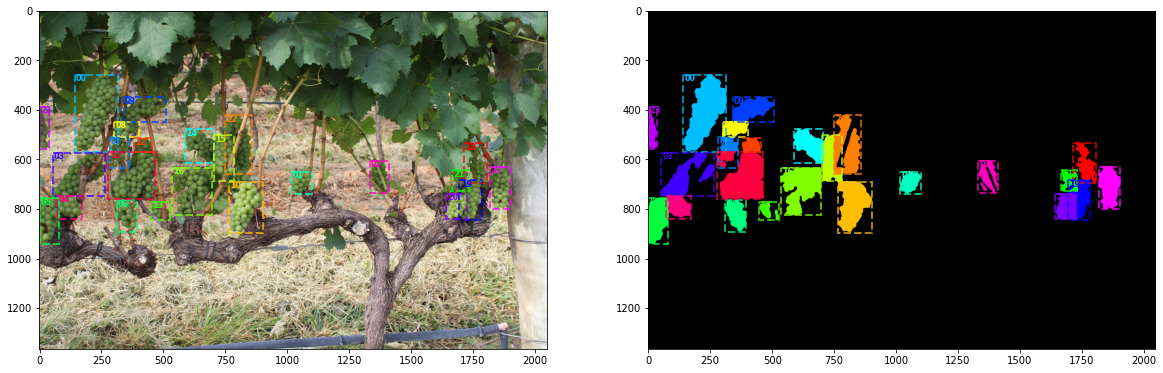

In [ ]:
def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def show_item(img, boxes, mask):

    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2)
    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)

dataiter = iter(train_loader)
images, targets = next(dataiter)  
show_item(images[0].numpy(), targets[0]['boxes'].numpy(), targets[0]['masks'].numpy())

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained_backbone=True)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                  hidden_layer,
                                                  num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [ ]:
def train(model, train_loader, num_epochs):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)

  # Which params to freeze
  for param in model.backbone.parameters():
    param.requires_grad = False


  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

  for epoch in range(num_epochs):

      train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
      lr_scheduler.step()


In [ ]:
train(model, train_loader, 10)

Epoch: [0]  [ 0/69]  eta: 0:03:42  lr: 0.000016  loss: 1.1666 (1.1666)  loss_classifier: 0.3172 (0.3172)  loss_box_reg: 0.4684 (0.4684)  loss_mask: 0.2942 (0.2942)  loss_objectness: 0.0237 (0.0237)  loss_rpn_box_reg: 0.0632 (0.0632)  time: 3.2220  data: 2.4287  max mem: 3319
Epoch: [0]  [10/69]  eta: 0:02:31  lr: 0.000163  loss: 0.9581 (1.0068)  loss_classifier: 0.2538 (0.2515)  loss_box_reg: 0.4243 (0.4175)  loss_mask: 0.2369 (0.2368)  loss_objectness: 0.0237 (0.0326)  loss_rpn_box_reg: 0.0334 (0.0683)  time: 2.5710  data: 1.8084  max mem: 3319
Epoch: [0]  [20/69]  eta: 0:02:14  lr: 0.000310  loss: 1.0540 (1.0878)  loss_classifier: 0.2732 (0.2712)  loss_box_reg: 0.4504 (0.4578)  loss_mask: 0.2594 (0.2546)  loss_objectness: 0.0302 (0.0397)  loss_rpn_box_reg: 0.0403 (0.0644)  time: 2.7285  data: 1.9502  max mem: 3319
Epoch: [0]  [30/69]  eta: 0:01:47  lr: 0.000456  loss: 1.1375 (1.0967)  loss_classifier: 0.2862 (0.2689)  loss_box_reg: 0.4658 (0.4606)  loss_mask: 0.2659 (0.2571)  loss_ob

In [ ]:
train(model, train_loader, 10)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/69]  eta: 0:04:43  lr: 0.000016  loss: 3.4649 (3.4649)  loss_classifier: 0.6761 (0.6761)  loss_box_reg: 0.0547 (0.0547)  loss_mask: 1.9374 (1.9374)  loss_objectness: 0.6951 (0.6951)  loss_rpn_box_reg: 0.1016 (0.1016)  time: 4.1124  data: 2.9345  max mem: 2512
Epoch: [0]  [10/69]  eta: 0:02:35  lr: 0.000163  loss: 2.1404 (2.3392)  loss_classifier: 0.4102 (0.4169)  loss_box_reg: 0.1462 (0.1426)  loss_mask: 0.7847 (0.9833)  loss_objectness: 0.6840 (0.6783)  loss_rpn_box_reg: 0.0667 (0.1183)  time: 2.6281  data: 1.9401  max mem: 2950
Epoch: [0]  [20/69]  eta: 0:02:11  lr: 0.000310  loss: 2.1404 (2.2502)  loss_classifier: 0.4102 (0.4206)  loss_box_reg: 0.2555 (0.3425)  loss_mask: 0.6328 (0.7853)  loss_objectness: 0.6402 (0.5957)  loss_rpn_box_reg: 0.0822 (0.1062)  time: 2.6141  data: 1.9367  max mem: 3214
Epoch: [0]  [30/69]  eta: 0:01:46  lr: 0.000456  loss: 2.0467 (2.2376)  loss_classifier: 0.4063 (0.4260)  loss_box_reg: 0.6212 (0.4423)  loss_mask: 0.5706 (0.7319)  loss_ob